## Using GSKY to replace datacube

### This notebook will demonstrate the use of GSKY to retrieve and display landsat data.

#### Example 5

This is exacly like  examples 3 and 4 with the exception that you can specify an area larger than one tile. For this, identify the top left corner tile (e.g. -12_-35) and the bottom right corner tile (e.g. -11_-36). A BBox covering a square (or rectangle) with these tiles as reference points will be generated.

###### Specifics

- Converting a DEA notebook example to use GSKY instaed of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.
    -- where an area around a single point is calculated.

- This example can only use one sensor ("ls8") instead of three sensors as DEA has used.

- The required area is specified a tile from a list that shows the bounding boxes. 

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 18 December, 2019

### How to use

Use this notebook to display a GSKY layer corresponding to a time slice and bounding box (BBox) larger than one tile. For this, identify the top left corner tile (e.g. -12_-35) and the bottom right corner tile (e.g. -11_-36). A BBox covering a square (or rectangle) with these tiles as reference points will be generated.

Click [here](http://cmi.ga.gov.au/sites/default/files/2017-12/DEA%20Tiles_1.pdf) to view the tile map.


- Specify the name of layer in cell 2
    - layer = "landsat8_nbar_16day"
    - If necessary, uncomment its code block to see all available layers.

- Identify the available time positions (dates of data acquisitions) in cell 3
    - Give m,n values to display the range of dates (from 0 to n_times-1)
    - Give t=i to say which date to use, where i = 0 to n_times-1.

- Identify the tile ID in cell 4

- Specify the tile ID in cell 5
    - If you know another BBox with data (Tip: use TerriaMap to find) then type it in as,
        - bbox = (130.00, -27.00, 131.00, -29.00)

- Execute all cells from top to bottom.

In [1]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 18/10/2019; Last Modified: 14/01/2020  #
##########################################################

from owslib.wcs import WebCoverageService
from netCDF4 import Dataset
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import logging, sys
logging.disable(sys.maxsize)


### Specify the GSKY capabilities end URL below.  

Normally there are several GSKY layers in the dataset. You must select one layer to view the data. By uncommenting its code you can display all available layers.

In [2]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
layer = "landsat8_nbar_16day"
wcs = WebCoverageService(gsky_url, version='1.0.0')

# Uncomment below to see all layers.
#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

### A time slice must be specified to show the layer. 

To help identify a time slice, specify the start and end values as m,n below, which will show the time slices in that range. Then specify the time slice as 't = i', where i = 0 to n_times-1

In [3]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = 7
# print ("Total of", n_times,'timepositions:\n\n', time[m:n])

# The time slice whose data is to be displayed is specified below. 
t = 0

### Specify a bounding box

To specify an area to analyse, you must give its bounding box coordinates (in EPSG:4326). This can be done either by hard coding it as e.g. *BBoxes[0] = ['148.62,-35.14,149.32,-36.58']* or by giving a tile ID(s) to calculate the BBox. Only one BBox can be specified in a WCS query.

The tiles are approximately 1x1 degree areas the Australian continent is divided into. A list of these tiles and their bounding boxes can be seen by uncommenting its code below. For instance, tiles '15_-40' and '15_-41' together cover all of ACT plus some of the surroundings. Sydney is covered by '17_-39'. 

Click [here](http://cmi.ga.gov.au/sites/default/files/2017-12/DEA%20Tiles_1.pdf) to view the tile map.


In [4]:
tiles_list = {}
with open("tiles_bboxes_out.txt") as f:
    for line in f:
        (key, val) = line.split()
        tiles_list[str(key)] = val

# Uncomment below to see all tiles and ther BBoxes
#tiles_list

#### Select a tile to get its BBox, after verifying that the tile has some data for the chosen layer and time. (Tip: use TerriaMap to find out)

You can give a single tile as **" tiles = \['-11_-38'\] "** or two tiles as in **" tiles = \['-11_-38','-11_-40'\]"**, where the first tile is the top left corner and the second tile is the bottom right corner of the area to be plotted. The BBox will be generated from these and scaled to fit the plot. 


In [5]:
# Get the BBox from tiles. Specify one tile or two as top left and bottom right corners.
tiles = ['-10_-30','-8_-35']
bbox = [tiles_list[tiles[0]],tiles_list[tiles[1]]]
x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[1][14:20])
Y = float(bbox[1][21:27])
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 340)))

# It is important to send the bbox as a tuple in the call to GSKY server
bbox = (x,y,X,Y)

# If you know a BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ('150.52,-34.15,151.34,-33.56') # Sydney
bbox


(121.76, -26.41, 130.29, -31.93)

### A call is made to the GSKY server to get the data. 
The data is returned in NetCDF format which is loaded into memory as 'diskless NetCDF'

In [6]:
# Construct the URL for a WCS call and send it to the GSKY server.
# Style can be False Color (fc) or True Color (tc)
# This notebook uses only NetCDF and EPSG:4326. Hence, do not change these.
# If any error, the displayed URL can be opened in a browser to see the actual error message.
output = wcs.getCoverage(identifier=layer, Styles='tc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)

# Read the output into diskless NetCDF
nc = Dataset('dtemp.nc','r',diskless=True,persist=False, memory=output.read())
print(output.geturl())

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=121.76%2C-26.41%2C130.29%2C-31.93&time=2013-03-19T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=tc


### Reading directly from diskless NetCDF
In the cell below the data is directly read from memory. The three bands in 'nc' are combined into an array and plotted with matplotlib. It is important to convert the 'int16' values in the NetCDF file into 'np.float32' in the range 0 to 1. If not, the plot will not look right.

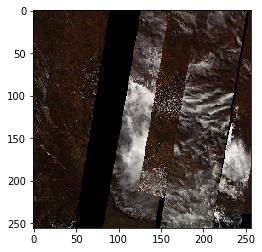

In [7]:
# Stack the three bands together and cast it as float32
# In the line below the 'axis=2' ensures that the data shape is 256,256,3
red = nc.variables['Band1'][:]
green = nc.variables['Band2'][:]
blue = nc.variables['Band3'][:]

rgb = np.stack([nc.variables['Band%d' % (b+1)] for b in range(3)], axis=2).astype(np.float32)
# rgb = np.stack([red, green, blue], axis=2).astype(np.float32)

# Convert all values into a range from 0 to 1. This is important.
rgb /= rgb.max()

# Uncomment next line to see the data values.
# print(rgb)

# Plot it
imgplot = plt.imshow(rgb)
plt.show()

### Plot the individual bands

You can plot the individual bands as well. It is not necessary to stack these or convert to float32

In [ ]:
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.colorbar()
plt.show

In [ ]:
plt.imshow(green, cmap = 'Greens')
plt.title('Green')
plt.colorbar()
plt.show

In [ ]:
plt.imshow(blue, cmap = 'Blues')
plt.colorbar()
plt.title('Blue')
plt.show

`Copyright` &copy; `2019 by National Computational Infrastructure (NCI).`